In [1]:
import datetime
import os

import numpy as np
import polars as pl

import joblib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

from PIL import Image
from pathlib import Path

from sklearn.preprocessing import StandardScaler
from sklearn.mixture import BayesianGaussianMixture
from sklearn.decomposition import PCA

from scipy.stats import rankdata


In [2]:
def scatter_each_classes(
    data: np.ndarray, 
    class_labels: list[int], 
    rank: np.ndarray, 
    markers: list[str], 
    colors: list[str], 
    xylabel: tuple[str, str], 
    face_color: str='valid', 
    scatter_classes: tuple[int, ...] | None = None
) -> None:
    labels = np.unique(class_labels) if scatter_classes is None else scatter_classes
    markers = markers if markers is not None else ['o'] * np.unique(class_labels).shape[0]
    colors = [plt.get_cmap('tab10')(i) for i in range(len(labels))] if colors == 'tab10' else colors
    print(markers)
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    if isinstance(colors, matplotlib.colors.LinearSegmentedColormap):
        for l, r in zip(labels, rank):
            if (face_color == 'None') and (markers[l] != 'x'):
                ax.scatter(data[class_labels==l, 0], data[class_labels==l, 1], edgecolors=colors(l / len(labels)), label=l, marker=markers[l], face_color=face_color, zorder=r)
            else:
                ax.scatter(data[class_labels==l, 0], data[class_labels==l, 1], c=colors(l / len(labels)), label=l, marker=markers[l], zorder=r)
    else:
        for l, r in zip(labels, rank):
            if (face_color == 'None') and (markers[l] != 'x'):
                ax.scatter(data[class_labels==l, 0], data[class_labels==l, 1], edgecolors=colors[l], label=l, marker=markers[l], face_color=face_color, zorder=r)
            else:
                ax.scatter(data[class_labels==l, 0], data[class_labels==l, 1], c=colors[l], label=l, marker=markers[l], zorder=r)

    y_range = ax.get_ylim()
    x_range = ax.get_ylim()
    max_abs_range = np.max(np.abs((y_range, x_range))) * 1.1

    ax.set_ylim(-max_abs_range, max_abs_range)
    ax.set_xlim(-max_abs_range, max_abs_range)
    ax.set_aspect('equal', 'datalim')
    
    ax.set_box_aspect(1)
    ax.set_xlabel(xylabel[0])
    ax.set_ylabel(xylabel[1])
    ax.legend(loc='upper left', bbox_to_anchor=(1,1))
    fig.tight_layout()
    plt.show()

In [3]:
x_range = (-4, 3)
y_range = (-9, 4)
max_abs_range = np.max(np.abs((y_range, x_range)))
max_abs_range

9

In [4]:
def concat_images(imgs, n_col, n_row, padding):
    w, h = imgs[0].size
    w_with_pad = w + padding
    h_with_pad = h + padding
    W = (w_with_pad) * n_col + padding
    H = (h_with_pad) * n_row + padding

    dst = Image.new('L', (W, H))
    iter_imgs = iter(imgs)
    for j in range(n_row):
        for i in range(n_col):
            img = next(iter_imgs)
            dst.paste(img, (padding + w_with_pad * i, padding + h_with_pad * j))
    return dst

In [5]:
def image_concat_and_imshow(df: pl.DataFrame, labels: list[int] | np.ndarray, colrow: tuple[int, int], image_root: str | Path) -> list[Image.Image]:
    if not isinstance(image_root, Path):
        image_root = Path(image_root)
        
    concat_imgs = []
    num_labels = len(np.unique(labels))
    
    for l in np.unique(labels):
        imgs = []
        file_paths = df.filter(pl.col("cluster") == l).sample(colrow[0] * colrow[1]).select("filepath").to_numpy().flatten()
        for p in file_paths:
            imgs.append(Image.open(image_root / p))
        concat_imgs.append(concat_images(imgs, colrow[0], colrow[1], 2))

    fig = plt.figure(figsize=(5,4))
    # fig.subplots_adjust(hspace=0.0, wspace=0.4)
    
    for i in range(num_labels):
        ax = fig.add_subplot(2, 5, i+1)
        ax.imshow(concat_imgs[i], "gray")
        ax.set_title(f'cluster {i}')
        ax.axis('off')
    
    # fig.tight_layout()
    plt.show()

    return concat_imgs

In [6]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
markers = ['s', 'D', 'o', 'p', '*', 'h', 'D', '8', 'v', 'x']

model_save_pardir = Path("../models/")
feature_pardir = Path("/home/shinsei/MyResearchs/feat_extrc/reports/features/SimpleCAE32/2023-07-10/13-09-32")
image_pardir = Path("/home/shinsei/MyResearchs/feat_extrc/data/processed/CNTForest/cnt_sem_32x32/10k/")

# feature_csv_path = "/home/shinsei/MyResearchs/feat_extrc/reports/features/SimpleCAE32/2023-07-07/12-15-24/features.csv"
feature_train_csv_path = feature_pardir / "features_train_data.csv"
feature_check_csv_path = feature_pardir / "features_check_data.csv"

In [7]:
df_train = pl.read_csv(feature_train_csv_path)
X_train = df_train.select([
    pl.exclude(["filename", "dirname"])
]).to_numpy()
df_train.head()

column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,column_36,…,column_93,column_94,column_95,column_96,column_97,column_98,column_99,column_100,column_101,column_102,column_103,column_104,column_105,column_106,column_107,column_108,column_109,column_110,column_111,column_112,column_113,column_114,column_115,column_116,column_117,column_118,column_119,column_120,column_121,column_122,column_123,column_124,column_125,column_126,column_127,dirname,filename
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,str
0.085531,0.652696,-0.304715,0.39652,-0.457528,-0.008066,0.455123,-0.260189,0.52101,-0.448034,0.420716,-0.357052,0.443164,0.67313,0.267822,0.324104,-0.2054,-0.477954,0.297364,0.053135,-0.370639,0.318801,-0.135448,-0.37164,-0.590236,0.50582,0.191822,0.859568,0.400706,-0.010296,0.55795,-0.245697,0.002591,-0.777151,0.018459,0.415641,-0.687229,…,0.472361,-0.154558,-0.005131,0.188563,0.079576,-0.361696,0.371474,-0.1703,-0.170322,0.037523,-0.755311,-0.255215,0.329084,-0.559039,0.148205,0.483929,0.462133,0.317056,-0.238316,0.278114,0.230168,-0.440027,0.23421,0.049672,0.186074,-0.156675,0.505174,0.087118,0.442726,1.243564,0.528567,-0.143065,0.580106,-0.298893,0.24718,0,"""10k_0_h000_w00…"
0.304032,-0.701261,-0.26386,-0.245357,-0.389596,0.761918,-0.568226,-0.235638,0.311917,-0.763101,0.783741,-0.75217,0.434609,0.101222,0.354738,0.759906,0.41262,1.118328,0.823532,-0.487695,0.468323,0.658648,0.227937,0.015848,0.186808,-0.782696,-0.028991,-0.333355,0.048682,-0.506766,-0.038069,-0.733807,-0.874561,0.34183,0.053467,0.069988,0.084812,…,0.355786,0.412587,0.41351,-0.298789,-0.319973,-0.211501,0.276795,0.22649,0.088694,-0.0274,0.063887,0.194498,-0.043691,0.245859,0.007315,-0.060991,-0.254315,-0.64672,0.418736,0.188339,-0.118252,-0.520708,-0.382059,-0.787909,0.194903,-0.442135,0.37631,-0.02227,0.08842,0.17507,0.402272,0.35253,0.218535,0.314572,0.778653,0,"""10k_0_h000_w00…"
-0.226996,0.206092,0.267804,-0.407874,0.59533,-0.003093,0.543326,0.310888,1.057553,-0.099924,-0.395329,0.199309,0.184412,0.150461,-0.124427,0.148694,-0.166455,0.525886,0.094284,0.533875,0.637336,0.467281,1.505668,-0.173979,-0.841741,-0.228452,-0.457033,0.420776,0.089381,-0.200824,0.896434,0.800856,-0.56494,0.089009,0.191202,0.045583,0.805474,…,0.6102,-0.004696,0.992365,-0.725928,0.454414,0.591591,-0.061863,0.313815,-0.816505,-0.077432,-0.477634,-0.493816,0.203505,0.197507,-0.238047,0.759813,-0.374865,-0.792639,0.164271,-0.012631,0.299948,0.119889,0.203693,-0.61076,0.038902,0.042869,0.350471,-0.213892,0.430622,-0.910724,0.375349,-0.599376,0.465569,0.14813,0.228808,0,"""10k_0_h000_w00…"
-0.091176,-0.047058,0.350275,0.096058,0.929412,0.439195,-0.430148,0.29032,-0.194786,-0.231615,0.915085,0.184923,0.097621,0.034589,-0.513159,-0.605927,-0.01308,0.437457,-1.102378,0.090877,0.63695,-0.493245,-0.610627,0.10154,-0.079199,0.004654,0.848289,0.156647,-0.171634,-0.293844,0.539354,0.136637,0.183676,0.217675,-0.919009,-0.233645,-0.39545,…,-1.085472,-0.293937,0.480533,-0.066618,0.079391,0.561128,-0.341484,-0.138819,-0.885809,0.607815,-0.541686,-0.476046,0.240496,-0.929571,0.001208,0.491959,-0.557757,0.578768,0.176877,0.500953,0.255943,0.028367,0.097295,0.479268,0.409907,-0.402908,0.397699,0.185982,0.493886,-0.182111,-0.469971,0.350064,0.068668,0.289092,0.364898,0,"""10k_0_h000_w00…"
-0.478116,0.632162,0.032764,0.107446,0.176951,-0.262379,-0.195815,0.255405,0.505611,0.050948,0.413968,0.077098,0.688337,0.484114,-0.754212,-0.294408,-0.710932,0.533701,-0.146862

In [8]:
df_check = pl.read_csv(feature_check_csv_path)
X_check = df_check.select([
    pl.exclude(["filename", "dirname"])
]).to_numpy()
df_check.head()

column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,column_36,…,column_93,column_94,column_95,column_96,column_97,column_98,column_99,column_100,column_101,column_102,column_103,column_104,column_105,column_106,column_107,column_108,column_109,column_110,column_111,column_112,column_113,column_114,column_115,column_116,column_117,column_118,column_119,column_120,column_121,column_122,column_123,column_124,column_125,column_126,column_127,dirname,filename
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,str
0.081187,0.641306,-0.29807,0.392791,-0.463166,-0.01242,0.454063,-0.266112,0.517888,-0.4535,0.41035,-0.357184,0.435353,0.665033,0.253357,0.323617,-0.210334,-0.466924,0.293595,0.048125,-0.369211,0.311697,-0.15129,-0.361674,-0.582406,0.513421,0.17603,0.861688,0.389199,-0.031552,0.546803,-0.246826,-0.01077,-0.774627,0.009406,0.416058,-0.686513,…,0.460027,-0.165335,0.000734,0.184057,0.065019,-0.36605,0.356607,-0.180316,-0.165681,0.02002,-0.757273,-0.2726,0.316256,-0.562363,0.159933,0.470357,0.451203,0.316254,-0.242803,0.277422,0.208594,-0.428476,0.23064,0.045281,0.182319,-0.168563,0.496287,0.086871,0.423506,1.223074,0.520453,-0.160121,0.579021,-0.293285,0.232095,0,"""10k_0_h000_w00…"
-0.240604,0.186281,0.280357,-0.407733,0.591664,-0.003713,0.541309,0.310418,1.050839,-0.113707,-0.409277,0.196771,0.183466,0.143439,-0.147569,0.150694,-0.164402,0.524919,0.099723,0.526067,0.638474,0.457185,1.4941,-0.167325,-0.837436,-0.217173,-0.466745,0.427481,0.072993,-0.217203,0.892269,0.79581,-0.573997,0.089553,0.184387,0.052235,0.801418,…,0.593655,-0.017438,0.996491,-0.728317,0.444236,0.585103,-0.090143,0.308813,-0.81049,-0.10033,-0.476777,-0.503833,0.195189,0.188452,-0.218358,0.750219,-0.38594,-0.783674,0.158368,-0.00145,0.284141,0.128518,0.19822,-0.610342,0.039718,0.030443,0.344347,-0.215181,0.409776,-0.919662,0.368075,-0.610561,0.465858,0.147057,0.215668,0,"""10k_0_h000_w00…"
-0.488357,0.622537,0.039477,0.107401,0.167747,-0.263835,-0.197042,0.246984,0.506997,0.04473,0.403341,0.074363,0.682993,0.478376,-0.764804,-0.288972,-0.710901,0.537684,-0.145632,0.006442,-0.077593,-0.055091,-0.441037,-0.004357,-0.424964,0.081613,0.50264,0.004408,-0.125338,-0.081806,-0.225509,-0.194922,-0.025063,0.114091,0.552873,0.360022,-0.211636,…,0.192154,0.763826,-0.089129,-0.718762,-0.278203,0.749432,-0.653637,-0.009453,0.236249,0.23363,-0.785358,0.006613,-0.47849,-0.070813,-0.258218,-0.749164,-0.191288,0.127218,1.022747,0.555098,0.516802,0.501803,-0.678717,0.214815,-0.028941,-0.447416,0.281469,-0.853215,0.129239,0.519929,-0.250867,-0.508604,0.331913,-0.052148,0.051363,0,"""10k_0_h000_w00…"
0.14232,0.833983,0.044417,0.02871,0.28038,0.384736,0.728963,0.417456,0.308815,0.444215,0.388266,-0.531925,0.456765,0.138868,1.056183,-0.425641,0.320917,0.196895,0.071539,0.404908,-0.74635,0.284718,0.343171,-0.938629,-0.971037,0.591346,-0.779473,0.899692,-0.359922,-0.163241,0.803512,0.069276,-0.746752,0.746933,0.383587,-0.558369,-0.072739,…,0.909676,0.331257,-0.0441,0.302166,0.239553,0.354353,0.18268,0.08521,-0.761343,-0.446473,0.304414,-0.952067,-0.047888,-0.554721,0.214581,0.011604,0.392295,0.166104,0.490512,-0.071409,1.012665,0.971091,0.136275,0.075375,-0.548449,0.272786,0.264022,0.351493,-0.281979,0.358343,0.698304,-0.844583,0.143866,-0.191383,-0.360749,0,"""10k_0_h000_w00…"
0.297355,0.001727,0.311982,-0.658734,0.514037,0.085714,0.02021,-0.435643,-0.04251,-0.374594,0.147983,-0.112143,-0.442718,0.002179,-0.409567,0.397173,0.304804,0.197853,-0.5968

In [9]:
try:
    image_paths_and_clusters = df_check.select([pl.col("filepath"), pl.col("cluster")]).to_numpy()
except:
    image_paths_and_clusters = df_check.select([pl.concat_str([pl.col("dirname"), pl.col("filename")], separator="/"), pl.col("cluster")]).to_numpy()

ColumnNotFoundError: cluster

Error originated just after this operation:
DF ["column_0", "column_1", "column_2", "column_3"]; PROJECT */130 COLUMNS; SELECTION: "None"

In [9]:
sc = StandardScaler()
pca = PCA()

X_train_std = sc.fit_transform(X_train)
X_train_pca = pca.fit_transform(X_train_std)

X_check_std = sc.transform(X_check)
X_check_pca = pca.transform(X_check_std)

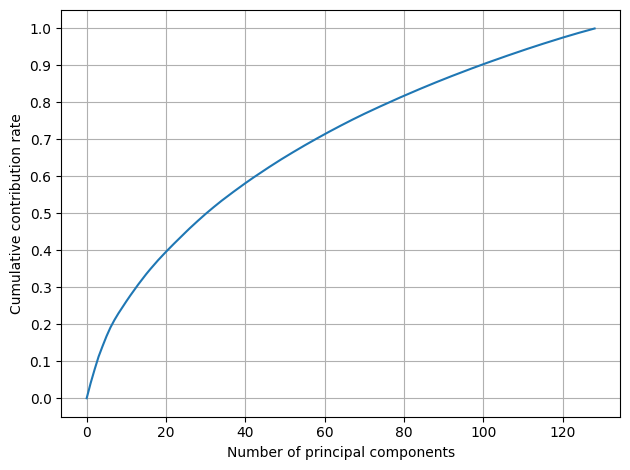

In [10]:
cumsum_contrb_rate = pca.explained_variance_ratio_.cumsum()

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(range(X_train.shape[1]+1), [0]+list(cumsum_contrb_rate))
ax.set_xlabel('Number of principal components')
ax.set_ylabel('Cumulative contribution rate')
ax.set_yticks(np.arange(0., 1.1, 0.1))
ax.grid()
fig.tight_layout()
plt.show()

In [11]:
num_use_features = cumsum_contrb_rate[cumsum_contrb_rate < 0.5].shape[0]
num_use_features

30

vbgmm_pca_30_10clusters


/home/shinsei/MyResearchs/feat_extrc/.venv/lib/python3.10/site-packages/sklearn/mixture/_base.py:268: ConvergenceWarning: Initialization 10 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


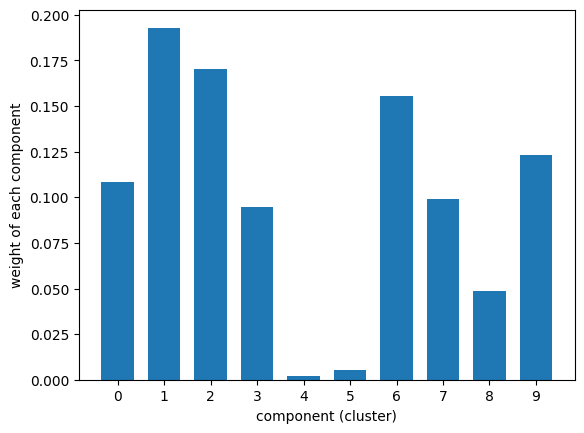

In [12]:
dt = datetime.datetime.now()
nc = 10

clustering_type = f'vbgmm_pca_{num_use_features}_{nc}clusters'
print(clustering_type)

vbgmm_train_pca = BayesianGaussianMixture(
    n_components=nc,
    max_iter=500,
    n_init=10,
    init_params="k-means++"
)
y_train_pca = vbgmm_train_pca.fit_predict(X_train_pca[:,:num_use_features])

# vbgmm_train_pca: BayesianGaussianMixture = joblib.load("/workdir/notebooks/vbgmm_train_pca.pkl")
# y_train_pca = vbgmm_train_pca.predict(X_train_pca[:,:num_use_features])

model_save_dir = model_save_pardir / "VBGMM" / dt.strftime("%Y-%m-%d/%H-%M-%S")

if not model_save_dir.exists():
    os.makedirs(model_save_dir)
joblib.dump(vbgmm_train_pca, model_save_dir / "vbgmm_train_pca.pkl")

rank_of_cluster_train_pca = rankdata(np.histogram(y_train_pca)[0], method='ordinal')
y_train_pca_sorted_cluster = rank_of_cluster_train_pca[y_train_pca]


# plt.subplot(4, 1, 4)
x_tick = np.arange(0, nc)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.bar(x_tick, vbgmm_train_pca.weights_, width=0.7, tick_label=x_tick)
plt.xlabel('component (cluster)')
plt.ylabel('weight of each component')
plt.show()

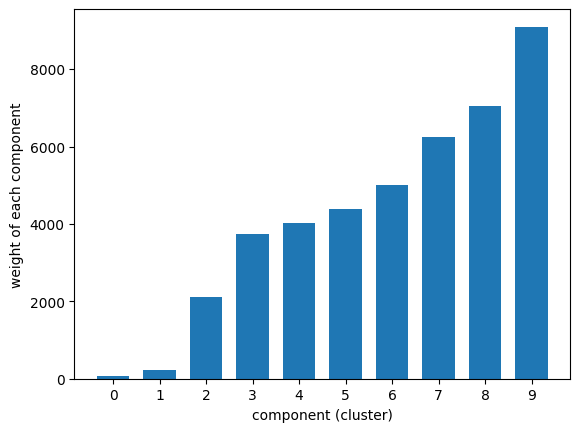

In [18]:
hist, bin_edges = np.histogram(y_train_pca_sorted_cluster)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.bar(x_tick, hist, width=0.7, tick_label=x_tick)
plt.xlabel('component (cluster)')
plt.ylabel('weight of each component')
plt.show()

In [26]:
make_file_path_col = pl.concat_str([pl.col("dirname"), pl.col("filename")], separator="/").alias("filepath")
df_train_clustering = df_train.with_columns(
    [make_file_path_col, pl.Series("cluster", y_train_pca_sorted_cluster-1)]
)
df_train_clustering.write_csv(feature_pardir / "feature_train_data_clustering.csv")

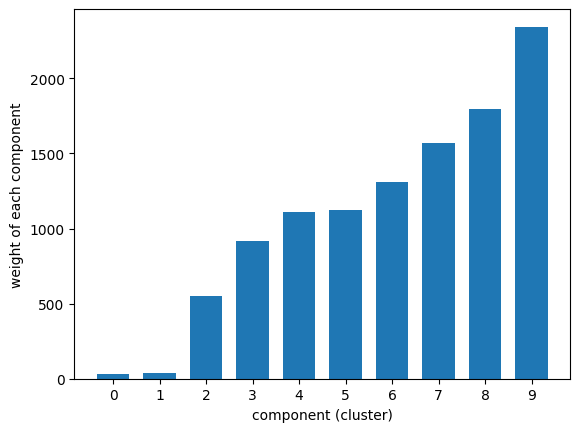

In [28]:
y_check_pca = vbgmm_train_pca.predict(X_check_pca[:, :num_use_features])
y_check_pca_sorted_cluster = rank_of_cluster_train_pca[y_check_pca]

hist, bin_edges = np.histogram(y_check_pca_sorted_cluster)

fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.bar(x_tick, hist, width=0.7, tick_label=x_tick)
plt.xlabel('component (cluster)')
plt.ylabel('weight of each component')
plt.show()

['s', 'D', 'o', 'p', '*', 'h', 'D', '8', 'v', 'x']


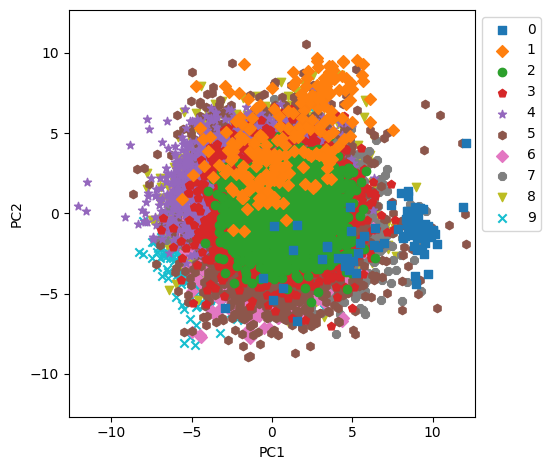

In [36]:
# df_train_clustering = pl.read_csv("/home/shinsei/MyResearchs/feat_extrc/reports/features/SimpleCAE32/2023-07-10/13-09-32/feature_train_data_clustering.csv")
# scatter_data = df_train_clustering.select([pl.exclude(["dirname", "filename", "filepath", "cluster"])]).to_numpy()
cluster_labels = df_train_clustering.select(pl.col("cluster")).to_numpy().flatten()
scatter_each_classes(
    X_train_pca, 
    cluster_labels, 
    np.arange(0, 10)[::-1],
    markers,
    colors,
    xylabel=("PC1", "PC2")
)

In [37]:
df_train_clustering.head()

column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,column_36,…,column_95,column_96,column_97,column_98,column_99,column_100,column_101,column_102,column_103,column_104,column_105,column_106,column_107,column_108,column_109,column_110,column_111,column_112,column_113,column_114,column_115,column_116,column_117,column_118,column_119,column_120,column_121,column_122,column_123,column_124,column_125,column_126,column_127,dirname,filename,filepath,cluster
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,str,str,i64
0.085531,0.652696,-0.304715,0.39652,-0.457528,-0.008066,0.455123,-0.260189,0.52101,-0.448034,0.420716,-0.357052,0.443164,0.67313,0.267822,0.324104,-0.2054,-0.477954,0.297364,0.053135,-0.370639,0.318801,-0.135448,-0.37164,-0.590236,0.50582,0.191822,0.859568,0.400706,-0.010296,0.55795,-0.245697,0.002591,-0.777151,0.018459,0.415641,-0.687229,…,-0.005131,0.188563,0.079576,-0.361696,0.371474,-0.1703,-0.170322,0.037523,-0.755311,-0.255215,0.329084,-0.559039,0.148205,0.483929,0.462133,0.317056,-0.238316,0.278114,0.230168,-0.440027,0.23421,0.049672,0.186074,-0.156675,0.505174,0.087118,0.442726,1.243564,0.528567,-0.143065,0.580106,-0.298893,0.24718,0,"""10k_0_h000_w00…","""0/10k_0_h000_w…",2
0.304032,-0.701261,-0.26386,-0.245357,-0.389596,0.761918,-0.568226,-0.235638,0.311917,-0.763101,0.783741,-0.75217,0.434609,0.101222,0.354738,0.759906,0.41262,1.118328,0.823532,-0.487695,0.468323,0.658648,0.227937,0.015848,0.186808,-0.782696,-0.028991,-0.333355,0.048682,-0.506766,-0.038069,-0.733807,-0.874561,0.34183,0.053467,0.069988,0.084812,…,0.41351,-0.298789,-0.319973,-0.211501,0.276795,0.22649,0.088694,-0.0274,0.063887,0.194498,-0.043691,0.245859,0.007315,-0.060991,-0.254315,-0.64672,0.418736,0.188339,-0.118252,-0.520708,-0.382059,-0.787909,0.194903,-0.442135,0.37631,-0.02227,0.08842,0.17507,0.402272,0.35253,0.218535,0.314572,0.778653,0,"""10k_0_h000_w00…","""0/10k_0_h000_w…",9
-0.226996,0.206092,0.267804,-0.407874,0.59533,-0.003093,0.543326,0.310888,1.057553,-0.099924,-0.395329,0.199309,0.184412,0.150461,-0.124427,0.148694,-0.166455,0.525886,0.094284,0.533875,0.637336,0.467281,1.505668,-0.173979,-0.841741,-0.228452,-0.457033,0.420776,0.089381,-0.200824,0.896434,0.800856,-0.56494,0.089009,0.191202,0.045583,0.805474,…,0.992365,-0.725928,0.454414,0.591591,-0.061863,0.313815,-0.816505,-0.077432,-0.477634,-0.493816,0.203505,0.197507,-0.238047,0.759813,-0.374865,-0.792639,0.164271,-0.012631,0.299948,0.119889,0.203693,-0.61076,0.038902,0.042869,0.350471,-0.213892,0.430622,-0.910724,0.375349,-0.599376,0.465569,0.14813,0.228808,0,"""10k_0_h000_w00…","""0/10k_0_h000_w…",9
-0.091176,-0.047058,0.350275,0.096058,0.929412,0.439195,-0.430148,0.29032,-0.194786,-0.231615,0.915085,0.184923,0.097621,0.034589,-0.513159,-0.605927,-0.01308,0.437457,-1.102378,0.090877,0.63695,-0.493245,-0.610627,0.10154,-0.079199,0.004654,0.848289,0.156647,-0.171634,-0.293844,0.539354,0.136637,0.183676,0.217675,-0.919009,-0.233645,-0.39545,…,0.480533,-0.066618,0.079391,0.561128,-0.341484,-0.138819,-0.885809,0.607815,-0.541686,-0.476046,0.240496,-0.929571,0.001208,0.491959,-0.557757,0.578768,0.176877,0.500953,0.255943,0.028367,0.097295,0.479268,0.409907,-0.402908,0.397699,0.185982,0.493886,-0.182111,-0.469971,0.350064,0.068668,0.289092,0.364898,0,"""10k_0_h000_w00…","""0/10k_0_h000_w…",9
-0.478116,0.632162,0.032764,0.107446,0.176951,-0.262379,-0.195815,0.255405,0.505611,0.050948,0.413968,0.077098,0.688337,0.484114,-0.754212,-0.294408,-0.710932,0.53370

In [34]:
make_file_path_col = pl.concat_str([pl.col("dirname"), pl.col("filename")], separator="/").alias("filepath")
df_check_clustering = df_check.with_columns(
    [make_file_path_col, pl.Series("cluster", y_check_pca_sorted_cluster-1)]
)
df_check_clustering.write_csv(feature_pardir / "feature_check_data_clustering.csv")
df_check_clustering.head()

column_0,column_1,column_2,column_3,column_4,column_5,column_6,column_7,column_8,column_9,column_10,column_11,column_12,column_13,column_14,column_15,column_16,column_17,column_18,column_19,column_20,column_21,column_22,column_23,column_24,column_25,column_26,column_27,column_28,column_29,column_30,column_31,column_32,column_33,column_34,column_35,column_36,…,column_95,column_96,column_97,column_98,column_99,column_100,column_101,column_102,column_103,column_104,column_105,column_106,column_107,column_108,column_109,column_110,column_111,column_112,column_113,column_114,column_115,column_116,column_117,column_118,column_119,column_120,column_121,column_122,column_123,column_124,column_125,column_126,column_127,dirname,filename,filepath,cluster
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,i64,str,str,i64
0.081187,0.641306,-0.29807,0.392791,-0.463166,-0.01242,0.454063,-0.266112,0.517888,-0.4535,0.41035,-0.357184,0.435353,0.665033,0.253357,0.323617,-0.210334,-0.466924,0.293595,0.048125,-0.369211,0.311697,-0.15129,-0.361674,-0.582406,0.513421,0.17603,0.861688,0.389199,-0.031552,0.546803,-0.246826,-0.01077,-0.774627,0.009406,0.416058,-0.686513,…,0.000734,0.184057,0.065019,-0.36605,0.356607,-0.180316,-0.165681,0.02002,-0.757273,-0.2726,0.316256,-0.562363,0.159933,0.470357,0.451203,0.316254,-0.242803,0.277422,0.208594,-0.428476,0.23064,0.045281,0.182319,-0.168563,0.496287,0.086871,0.423506,1.223074,0.520453,-0.160121,0.579021,-0.293285,0.232095,0,"""10k_0_h000_w00…","""0/10k_0_h000_w…",2
-0.240604,0.186281,0.280357,-0.407733,0.591664,-0.003713,0.541309,0.310418,1.050839,-0.113707,-0.409277,0.196771,0.183466,0.143439,-0.147569,0.150694,-0.164402,0.524919,0.099723,0.526067,0.638474,0.457185,1.4941,-0.167325,-0.837436,-0.217173,-0.466745,0.427481,0.072993,-0.217203,0.892269,0.79581,-0.573997,0.089553,0.184387,0.052235,0.801418,…,0.996491,-0.728317,0.444236,0.585103,-0.090143,0.308813,-0.81049,-0.10033,-0.476777,-0.503833,0.195189,0.188452,-0.218358,0.750219,-0.38594,-0.783674,0.158368,-0.00145,0.284141,0.128518,0.19822,-0.610342,0.039718,0.030443,0.344347,-0.215181,0.409776,-0.919662,0.368075,-0.610561,0.465858,0.147057,0.215668,0,"""10k_0_h000_w00…","""0/10k_0_h000_w…",9
-0.488357,0.622537,0.039477,0.107401,0.167747,-0.263835,-0.197042,0.246984,0.506997,0.04473,0.403341,0.074363,0.682993,0.478376,-0.764804,-0.288972,-0.710901,0.537684,-0.145632,0.006442,-0.077593,-0.055091,-0.441037,-0.004357,-0.424964,0.081613,0.50264,0.004408,-0.125338,-0.081806,-0.225509,-0.194922,-0.025063,0.114091,0.552873,0.360022,-0.211636,…,-0.089129,-0.718762,-0.278203,0.749432,-0.653637,-0.009453,0.236249,0.23363,-0.785358,0.006613,-0.47849,-0.070813,-0.258218,-0.749164,-0.191288,0.127218,1.022747,0.555098,0.516802,0.501803,-0.678717,0.214815,-0.028941,-0.447416,0.281469,-0.853215,0.129239,0.519929,-0.250867,-0.508604,0.331913,-0.052148,0.051363,0,"""10k_0_h000_w00…","""0/10k_0_h000_w…",3
0.14232,0.833983,0.044417,0.02871,0.28038,0.384736,0.728963,0.417456,0.308815,0.444215,0.388266,-0.531925,0.456765,0.138868,1.056183,-0.425641,0.320917,0.196895,0.071539,0.404908,-0.74635,0.284718,0.343171,-0.938629,-0.971037,0.591346,-0.779473,0.899692,-0.359922,-0.163241,0.803512,0.069276,-0.746752,0.746933,0.383587,-0.558369,-0.072739,…,-0.0441,0.302166,0.239553,0.354353,0.18268,0.08521,-0.761343,-0.446473,0.304414,-0.952067,-0.047888,-0.554721,0.214581,0.011604,0.392295,0.166104,0.490512,-0.071409,1.012665,0.971091,0.136275,0.075375,-0.548449,0.272786,0.264022,0.351493,-0.281979,0.358343,0.698304,-0.844583,0.143866,-0.191383,-0.360749,0,"""10k_0_h000_w00…","""0/10k_0_h000_w…",4
0.297355,0.001727,0.311982,-0.658734,0.514037,0.085714,0.02021,-0.435643,-0.04251,-0.374594,0.147983,-0.112143,-0.442718,0.002179,-0.409567,0.397173,0.304804,0.197

In [7]:
df_check_clustering = pl.read_csv("/home/shinsei/MyResearchs/feat_extrc/reports/features/SimpleCAE32/2023-07-10/13-09-32/feature_check_data_clustering.csv")

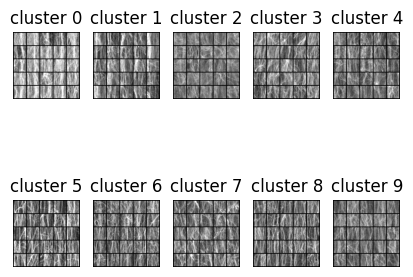

In [66]:
concatenated_images = image_concat_and_imshow(df_train_clustering, labels=np.arange(0,10), colrow=(5,5), image_root=image_pardir)
for i, img in enumerate(concatenated_images):
    img.save(f"/home/shinsei/MyResearchs/feat_extrc/reports/figures/VBGMM/2023-07-10/cluster{i}.png")

vbgmm_pca_30_100clusters


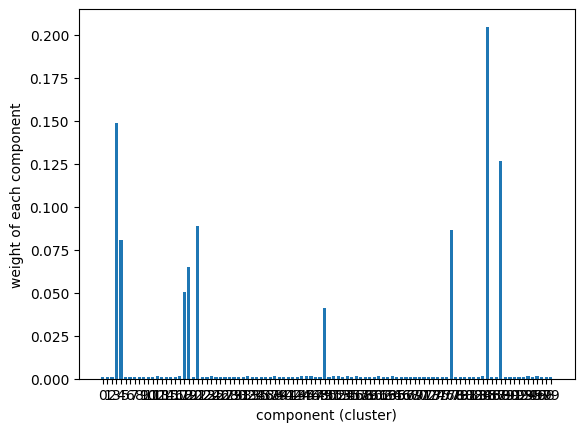

In [13]:
dt = datetime.datetime.now()

nc = 100

clustering_type = f'vbgmm_pca_{num_use_features}_{nc}clusters'
print(clustering_type)

vbgmm_train_pca_100 = BayesianGaussianMixture(
    n_components=nc,
    max_iter=500,
    n_init=10,
    init_params="k-means++"
)
y_train_pca = vbgmm_train_pca_100.fit_predict(X_train_pca[:,:num_use_features])

model_save_dir = model_save_pardir / dt.strftime("%Y-%m-%d/%H-%M-%S")
if not model_save_pardir.exists():
    os.makedirs(model_save_dir)
joblib.dump(model_save_dir / "vbgmm_train_pca_100.pkl")

rank_of_cluster_train_pca = rankdata(- vbgmm_train_pca_100.weights_, method='ordinal')
y_train_pca_sorted_cluster = rankdata[y_train_pca]

# plt.subplot(4, 1, 4)
x_tick = np.arange(0, nc)
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
plt.bar(x_tick, vbgmm_train_pca_100.weights_, width=0.7, tick_label=x_tick)
plt.xlabel('component (cluster)')
plt.ylabel('weight of each component')
plt.show()